In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

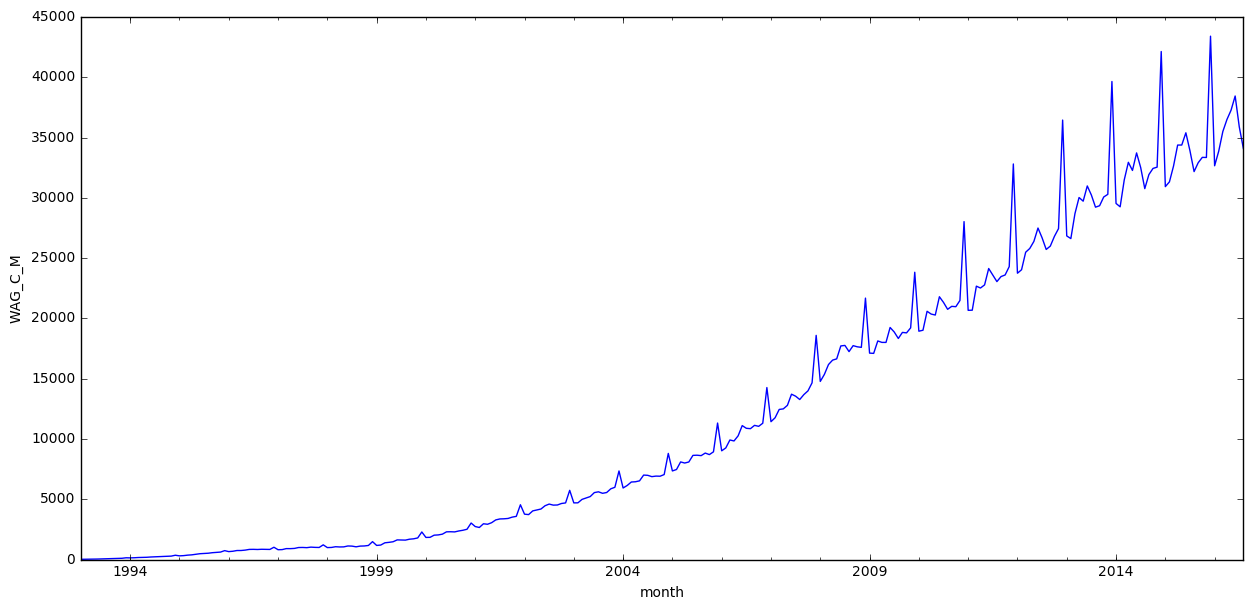

In [3]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

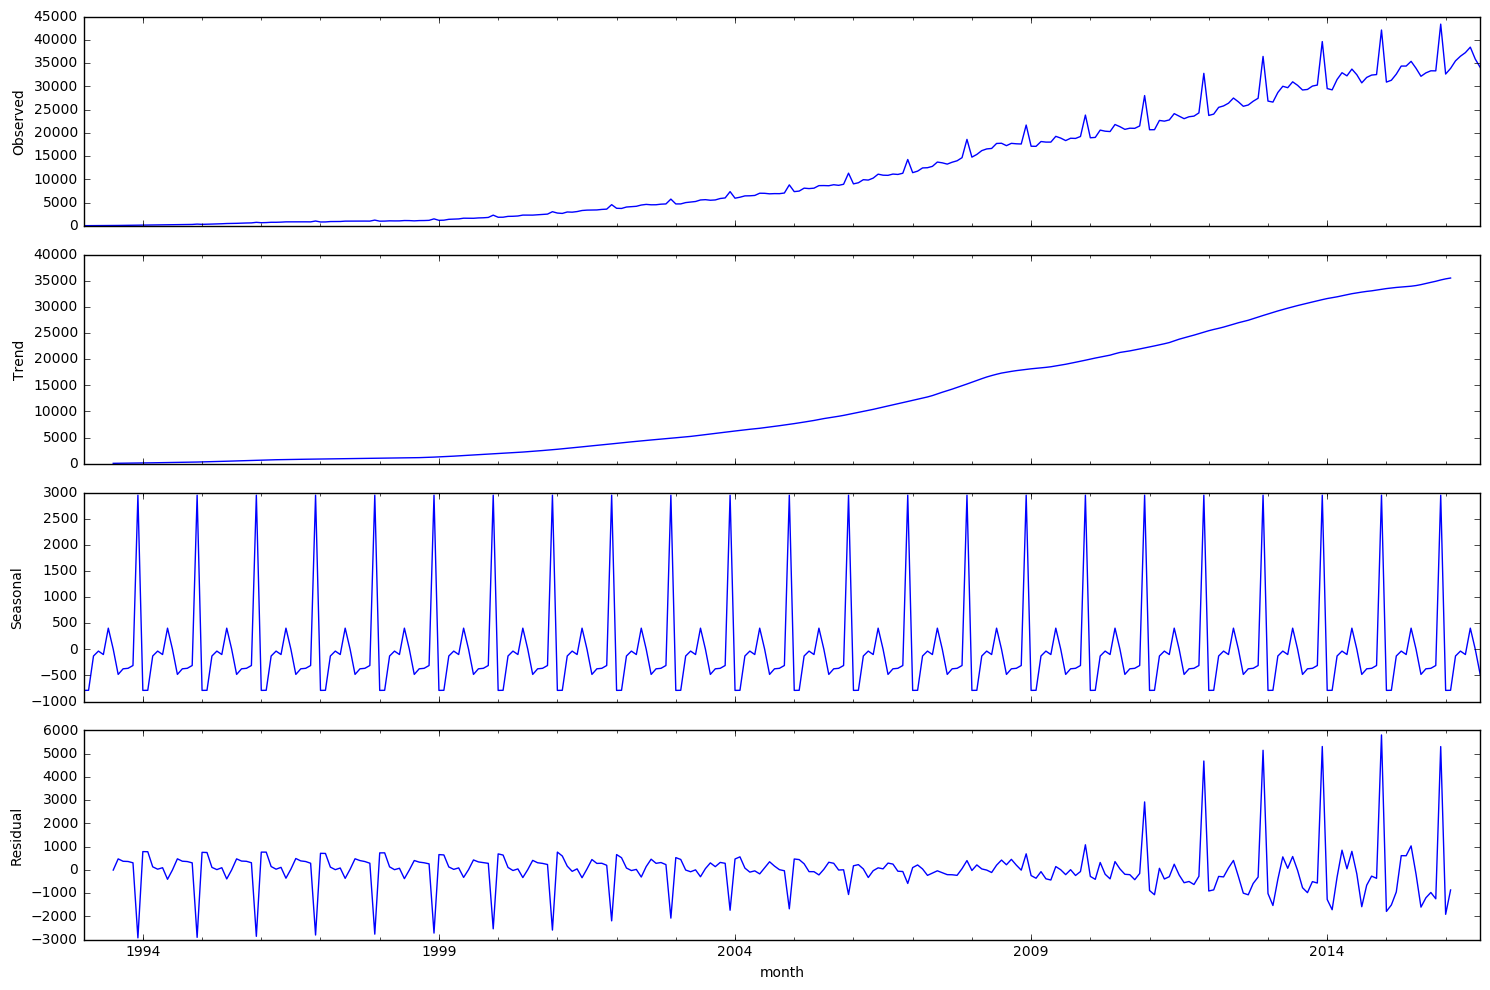

Критерий Дики-Фуллера: p=0.991850


In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
pylab.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Стабилизация дисперси

применим преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


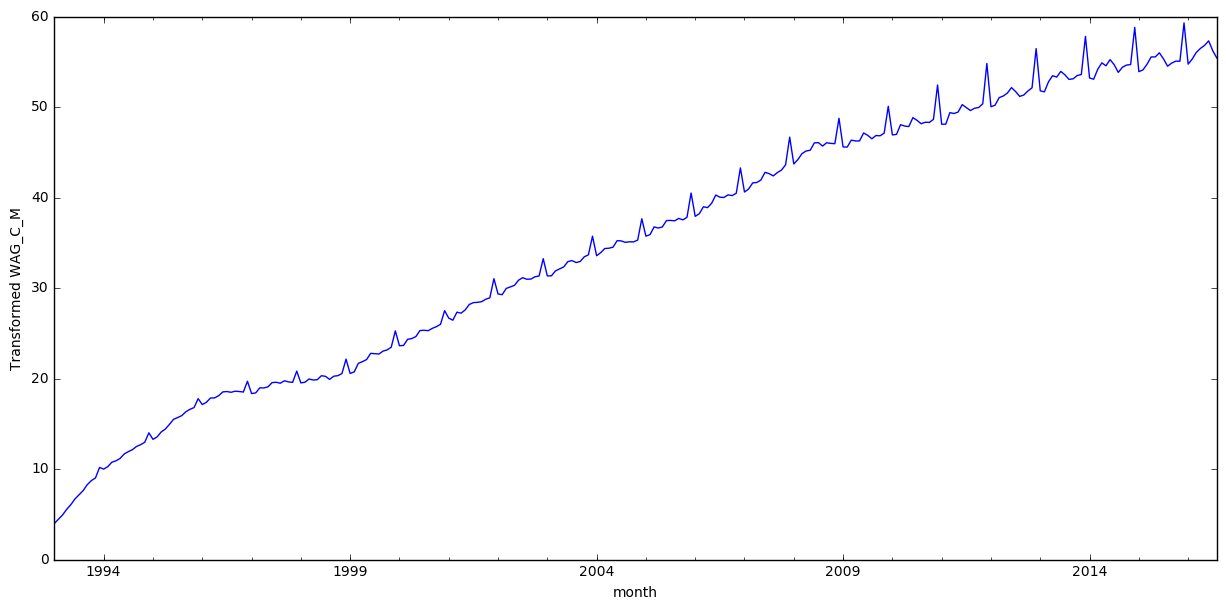

In [5]:
salary['box_WAG_C_M'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.box_WAG_C_M.plot()
plt.ylabel('Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_WAG_C_M)[1])

### Стационарность

Критерий Дики-Фуллера принимается - выборка нестационарна.

In [6]:
salary['box_diff_WAG']= salary.box_WAG_C_M-\
salary.box_WAG_C_M.shift(12)

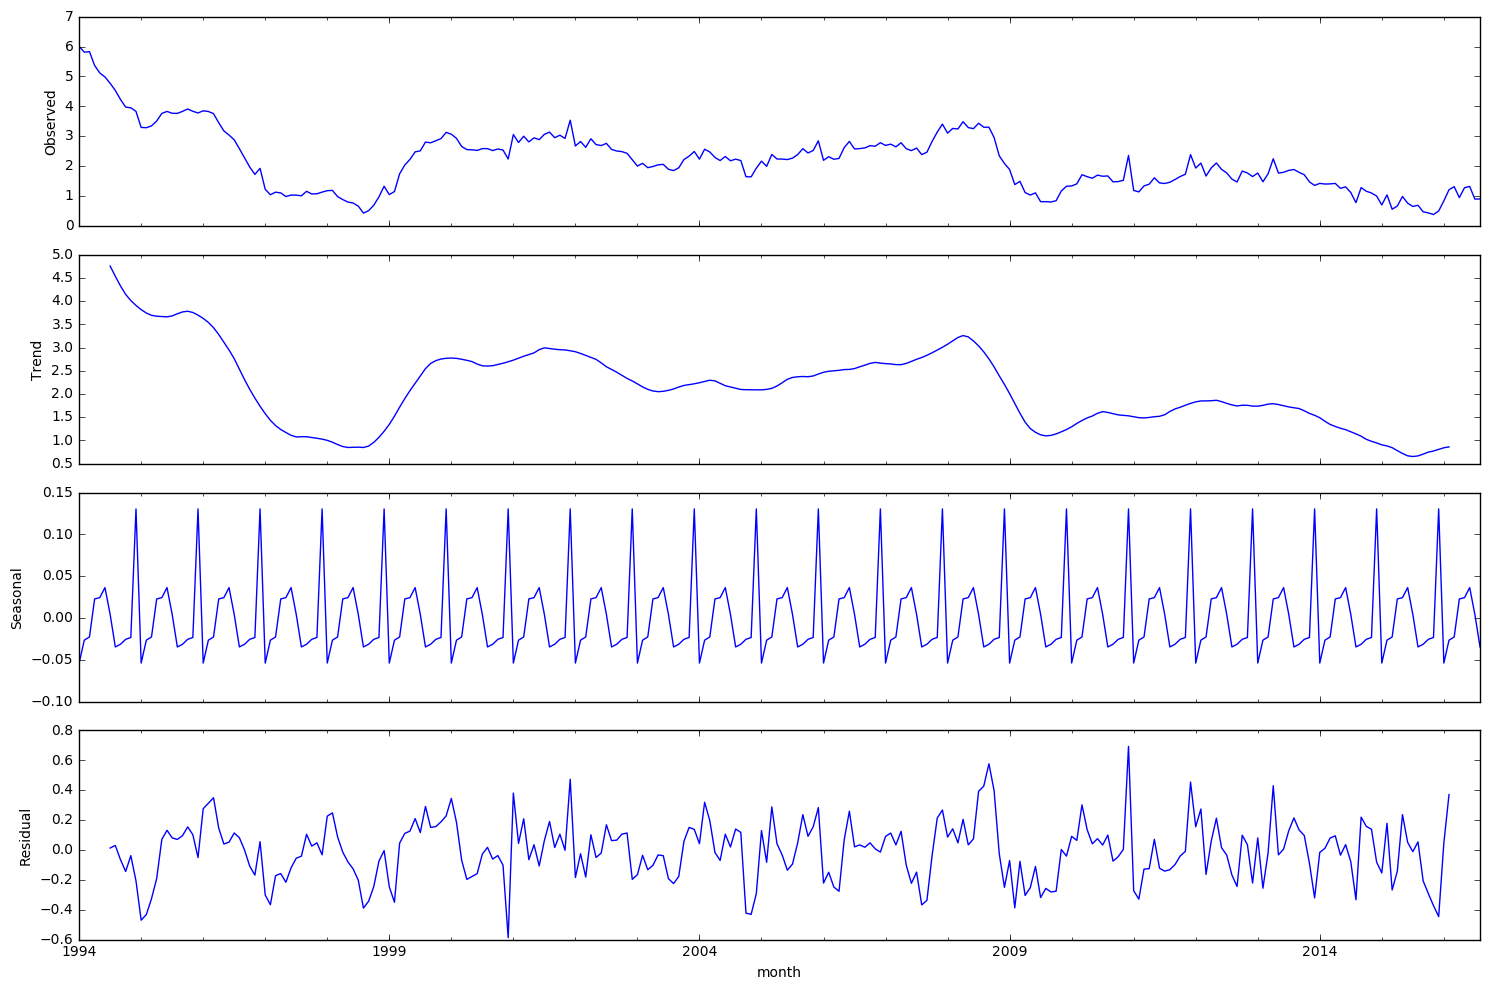

Критерий Дики-Фуллера: p=0.014697


In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff_WAG[12:]).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff_WAG[12:])[1])

Критерий Дики-Фуллера: p=0.000000


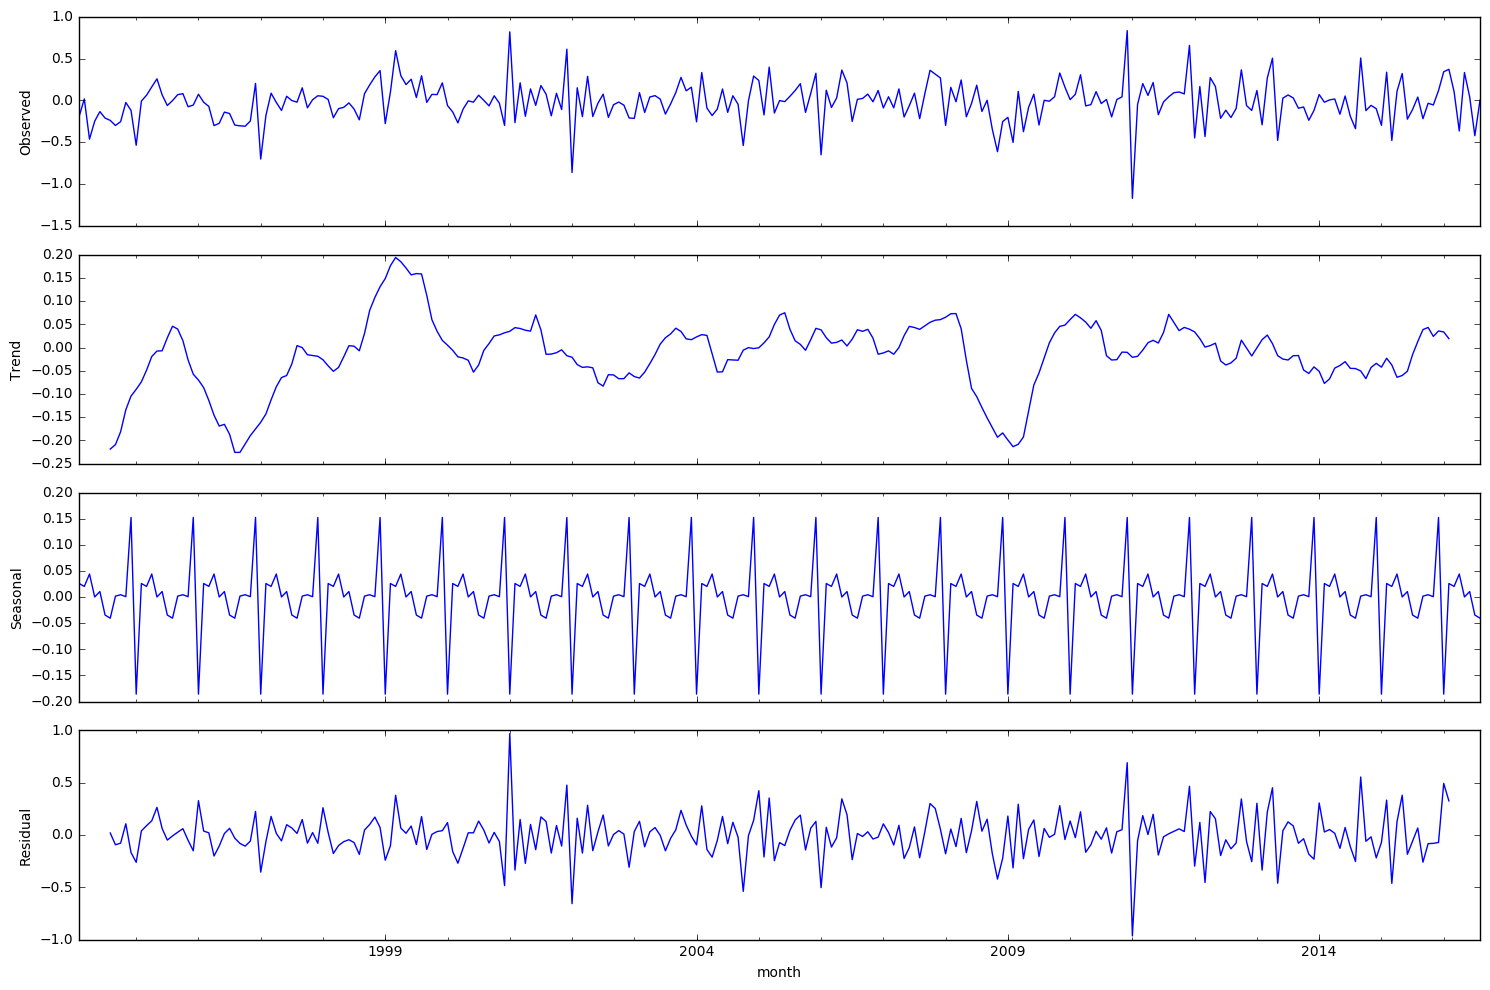

In [8]:
salary['box_diff_WAG2'] = salary.box_diff_WAG - salary.box_diff_WAG.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff_WAG2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff_WAG2[13:])[1])

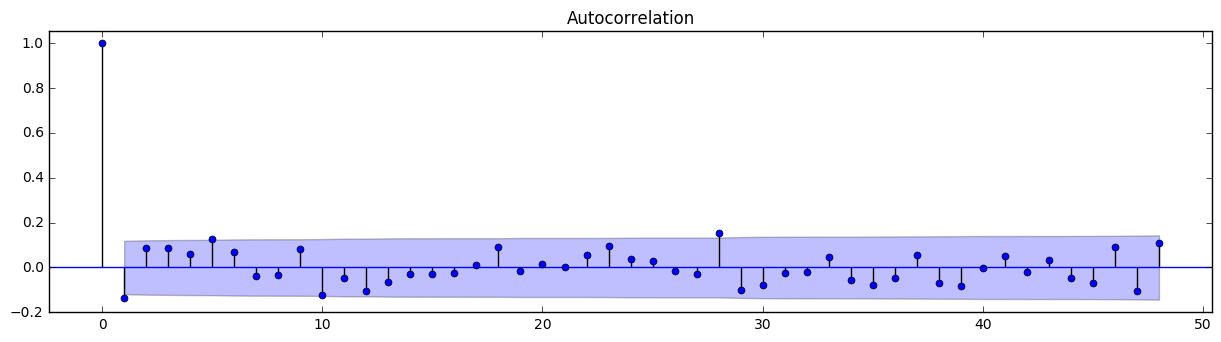

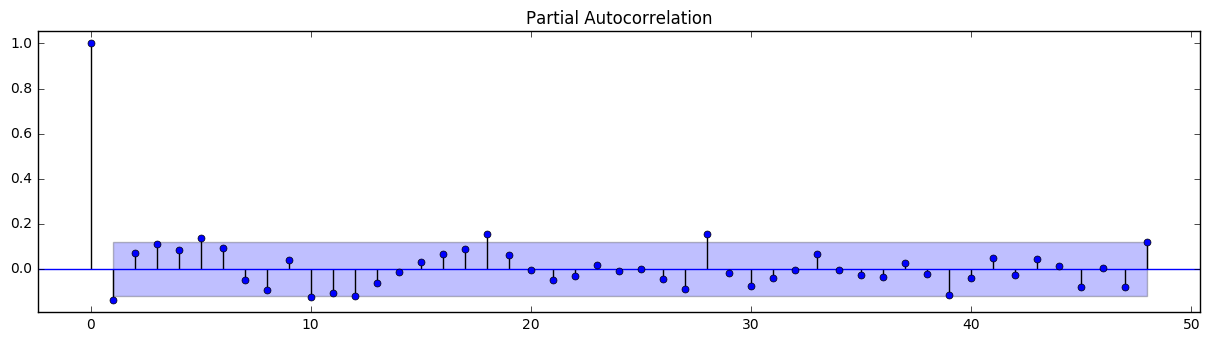

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.box_diff_WAG2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.box_diff_WAG2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Q=0, q = 5, P = 4, p = 5

In [ ]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = [0]

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [ ]:
# %%time
# results = []
# best_aic = float("inf")
# warnings.filterwarnings('ignore')

# for param in parameters_list:
#     #try except нужен, потому что на некоторых наборах параметров модель не обучается
#     try:
#         model=sm.tsa.statespace.SARIMAX(salary.box_WAG_C_M, order=(param[0], d, param[1]), 
#                                         seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#     #выводим параметры, на которых модель не обучается и переходим к следующему набору
#     except ValueError:
#         print('wrong parameters:', param)
#         continue
#     aic = model.aic
#     #сохраняем лучшую модель, aic, параметры
#     if aic < best_aic:
#         best_model = model
#         best_aic = aic
#         best_param = param
#     results.append([param, model.aic])
    
# warnings.filterwarnings('default')

In [12]:
import pickle

In [15]:
# with open("results","wb") as f:
#     pickle.dump(results,f)

In [23]:
with open("results","rb") as f:
    results = pickle.load(f)

In [ ]:
# save_best = (best_model,best_aic,best_param)
with open("best1","wb") as f:
    pickle.dump(model,f)
#     pickle.dump(save_best,f)b

In [13]:
best= None
with open("best","rb") as f:
    best = pickle.load(f)

In [15]:
param = best[1]

In [16]:
model=sm.tsa.statespace.SARIMAX(salary.box_WAG_C_M, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)b

/home/vad/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
130  (5, 5, 1, 0) -25.802708
131  (5, 5, 2, 0) -24.655770
133  (5, 5, 4, 0) -22.623401
132  (5, 5, 3, 0) -22.496373
129  (5, 5, 0, 0) -22.462118


In [30]:
with open("TRATATA","wb") as f:
    model.save(f)

In [26]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        box_WAG_C_M   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.901
Date:                            Sun, 26 Feb 2017   AIC                            -25.803
Time:                                    20:09:06   BIC                             17.985
Sample:                                01-01-1993   HQIC                            -8.247
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0150      4.760      0.003      0.997      -9.314       9.344
ar.L2          0.0116      3.205   

Критерий Стьюдента: p=0.190020
Критерий Дики-Фуллера: p=0.000000


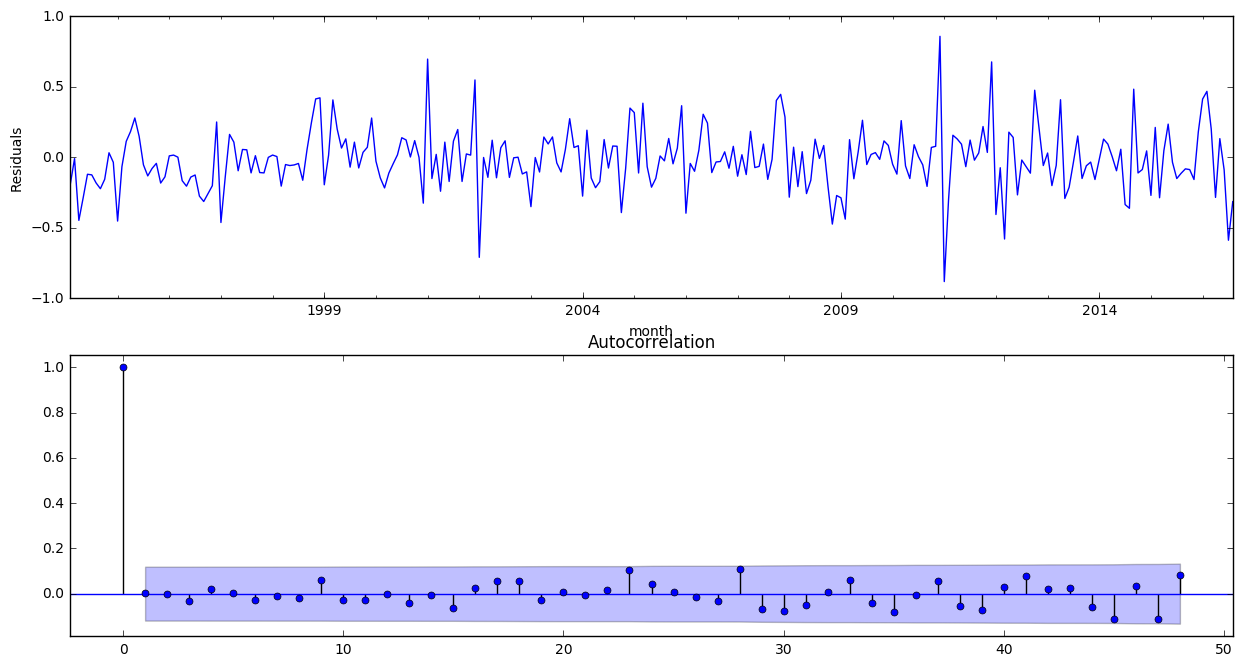

In [27]:
plt.figure(figsize(15,8))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])